# Bibliotecas, Visualização e Pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne


# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [2]:
def print_graphs(data):
    for i in range(0, 40, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 40, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 40, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregando a base de dados

In [4]:
data = np.load("../../dataset/beta/data.npy")

print(data.shape)

(160, 64, 750)


Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

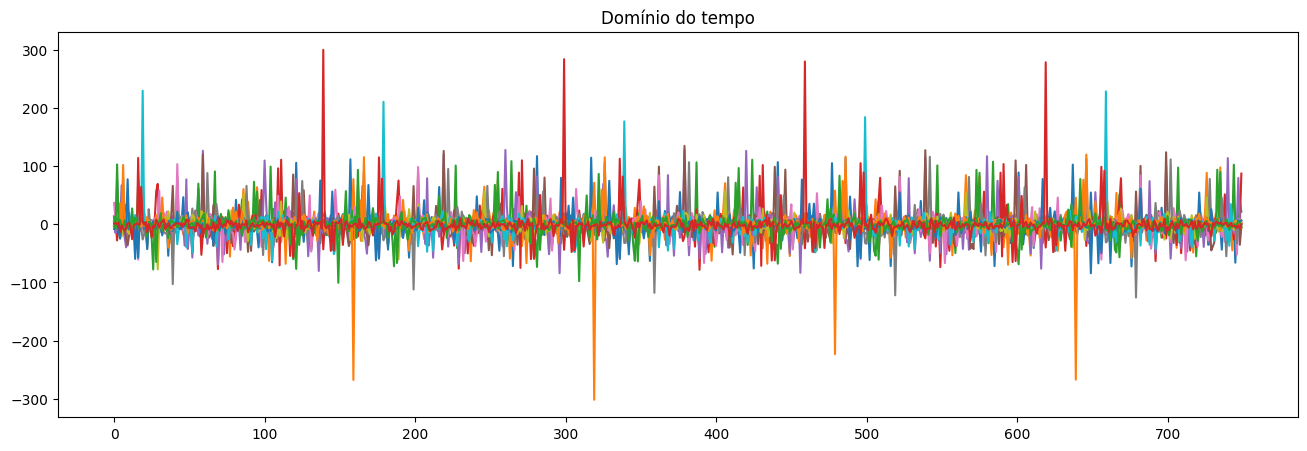

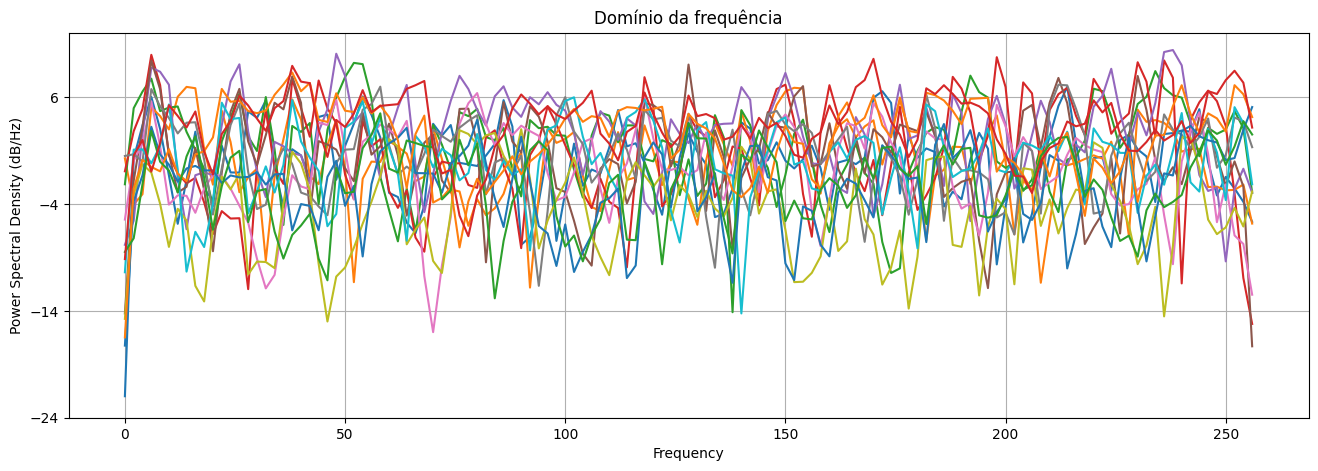

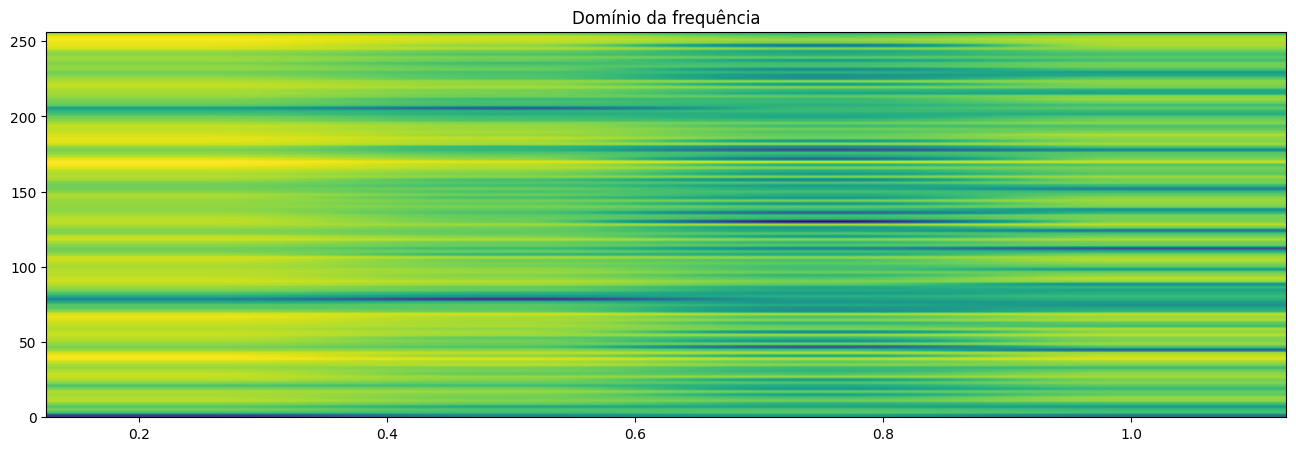

In [6]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data[0])

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [8]:
# criação de um objeto "info"
n_channels = 64
sfreq = 250
ch_names = list(np.load("../../dataset/beta/channels.npy"))
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 512.0 Hz
>

In [9]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../../dataset/beta/labels.npy")
labels.shape

(160,)

In [11]:
data_correct = data

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(160, dtype=int),
    le.fit_transform(labels))
)

event_dict = {'8':0, '8.2':1, '8.4':2, '8.6':3, '8.8':4, '9':5,
              '9.2':6, '9.4':7, '9.6':8, '9.8':9, '10':10, '10.2':11,
              '10.4':12, '10.6':13, '10.8':14, '11':15, '11.2':16, '11.4':17,
              '11.6':18, '11.8':19, '12':20, '12.2':21, '12.4':22, '12.6':23,
              '12.8':24, '13':25, '13.2':26, '13.4':27, '13.6':28, '13.8':29,
              '14':30, '14.2':31, '14.4':32, '14.6':33, '14.8':34, '15':35,
              '15.2':36, '15.4':37, '15.6':38, '15.8':39}

mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
filtered_mne_data = mne_data.filter(6, 18)
filtered_mne_data.save("beta.fif", overwrite=True)

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 6 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 845 samples (1.650 s)



C:\Users\gregu\AppData\Local\Temp\ipykernel_3932\4065809442.py:20: RuntimeWarning: filter_length (845) is longer than the signal (750), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_mne_data = mne_data.filter(6, 18)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_